In [2]:
"""In this project, we'll learn to identify lane lines in a video stream.  A video stream is really just
a bunch of images, so we'll begin by looking at just one image from the video.  We'll set up our 
algorithm by finding the lane lines in this one image, then apply it to the video.

"""

#let's have a look at our test image called 'test.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib qt

image = mpimg.imread('test.jpg')
print(type(image), image.shape)
plt.imshow(image)


<class 'numpy.ndarray'> (540, 960, 3)


In [ ]:
"""Have a look at the test image. With our eyes, we can easily identify the lane lines right?  So let's 
brainstorm ways we might be able to identify them with an algorithm... what kind of features do you think
we could use to identify the lane lines in the image?

To start with, we're going to go with color as a major identifier of the lines, because they're white, and most of
the pixels in the image are some other color.  We have our image stored in the variable 'image', which is an array 
with shape (y, x, color depth) = (540, 960, 3).  Hence this is a 540 by 960 pixel 3 color image containing values for each
of Red, Green, and Blue (RGB).  Use the interactive matplotlib window (or whatever tools you like) to explore 
the colors of the lane lines themselves.  We'll use this to get rid of pixels in the image which do not fall 
into this range. 

(upon doing this exercise, we find the [R, G, B] range is something like [165, 165, 165] to [245, 245, 245])"""

In [3]:
"""next we'll define a function to select only the pixels within our color range for an image"""

#HERE THE STUDENT WILL DETERMINE THE COLOR RANGE BY PLAYING WITH THE TEST IMAGE IN MATPLOTLIB OR SIMILAR

def color_select(image):
    lower_white = np.array([165,165,165], dtype=np.uint8) #student fills in the numbers here
    upper_white = np.array([245,245,245], dtype=np.uint8) #student fills in the numbers here
    selected = cv2.inRange(image, lower_white, upper_white)
    return selected

In [4]:
"""Now we'll operate on the image and see what we get.  We'll also start using OpenCV to look at images.  The
result should pop up in a separate window"""
cselect = color_select(image)
plt.imshow(cselect, cmap='Greys_r')


In [5]:
"""Your output color selected image should look approximately like the sample color selected image.

We have now drastically simplified our image to contain binary values (0 or 255), where zeros correspond to pixels
that did not fall within the specified color range.  All the remaining pixels were similar in color to the lane lines.
We observe that, while the lane lines themselves are clearly visible, there are still a lot of other pixels, 
particularly in the sky portion of the frame, remaining.

At this point we will use to our advantage, the fact that we know the lane lines we're interested in only appear on
the road, so we can mask out portions of the image that are not relevant to our search.  To do this, we'll define a 
couple more funtions:"""

#HERE THE STUDENT WILL DETERMINE THE REGION OF INTEREST

#first just a convenience function that just returns a blank image the same size as the one we're working with
def blank(image):
    rows,cols = image.shape[:2]
    if len(image.shape) == 2:
        return np.zeros((rows, cols), np.uint8)
    else:
        return np.zeros((rows, cols, 3), np.uint8)
    
#second, a function that returns the Region of Interest or 'ROI', which is cropped image that no longer 
#contains areas we aren't interested in.
#in this case, we're throwing out the top 40% of the image, but keeping all the width

def roi(image):
    rows,cols = image.shape[:2]
    copy = image.copy()
    z = blank(image)
    copy[:round(rows*0.4),:] = z[:round(rows*0.4),:]
    return copy

In [6]:
#lets operate on our color selected image and see what we get
focus = roi(cselect)
plt.imshow(focus, cmap='Greys_r')

In [7]:
"""Ok, now we've got some nice lines to detect!  Next, we'll apply a Hough Transform to find lines in our 
edge-detected image.  The Hough transform can be used to detect various shapes in an image, but here we'll
use it to detect lines (more on the 'how' to come...  We'll write another couple functions here to perform 
the Hough transform and then draw the detected lines back onto our original image."""

#HERE THE STUDENT WILL NEED TO PLAY WITH THE HOUGH TRANSFORM PARAMETERS TO GET A REASONABLE RESULT

def houghLinesP(image, edges):
    minLineLength = 100
    maxLineGap = 10 
    lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
    drawLane(image, lines)
    return lines
    
def drawLane(image, lines):
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(image,(x1,y1),(x2,y2),(0,0,255),10)
    return


hough = blank(image)
lines = houghLinesP(hough, focus)
lineImage = cv2.bitwise_or(image, roi(hough))
plt.imshow(lineImage)

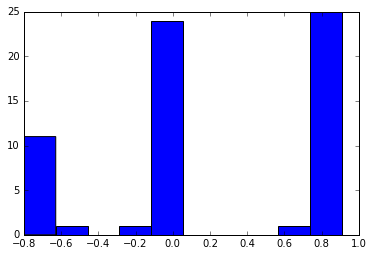

In [8]:
"""Ok, now we've got some nice line detections!  Clearly, some of the detections are our lane lines, but we've
picked up some other stuff as well.  Now we need to figure out how to select lane lines only from detected lines
and plot out the full lane on the image.  To do this let's start by investigating the slope of the lines"""

#our output 'lines' from above contains the x and y endpoints of all detected lines
#we'll use matplotlib to look at the slope distribution

#HERE THE STUDENT WILL NEED TO LOOK AT THE SLOPE HISTOGRAM (OR WHATEVER ELSE THEY LIKE) AND DETERMINE A SLOPE CUTOFF
import matplotlib.pyplot as plt
%matplotlib inline

x1,y1,x2,y2 = lines[:,0,0], lines[:,0,1], lines[:,0,2], lines[:,0,3]
slopes = (y2-y1)/(x2-x1) #rise over run

slope_hist = plt.hist(slopes)


In [10]:
"""Ok, so we've got slopes concentrated around 3 values, namely, around 0, and +/- 0.8.  We could investigate
deeper, but just looking at the image we can see that most of the stuff we don't want are probably the 
concentration of slope values near 0.  So lets impose a restriction on which lines we're going to draw based
on slope... To do this we'll redefine our drawLane function"""

slopeCut = 0.5 #student will change this value

def drawLane(image, lines):
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                rise = y2 - y1
                run = x2 - x1
                if run != 0:
                    slope = float(rise / run)
                    if np.absolute(slope) > slopeCut:
                        cv2.line(image,(x1,y1),(x2,y2),(0,0,255),10)
    return

hough = blank(image)
lines = houghLinesP(hough, focus)
lineImage = cv2.bitwise_or(image, roi(hough))

%matplotlib qt
plt.imshow(lineImage)


In [50]:
"""So, now we've got our lane lines identified, and we'd like to draw an estimate of where the 
lane is on the image.  To do this, fit a line to to all 
the detected line segments, and extrapolate up and 
down the road. Again, we'll redefine our 
drawLanes function
and our houghLinesP to include one more parameter..."""

#HERE I'M NOT SURE WHAT TO HAVE THE STUDENT DO, BUT MAYBE FIGURE OUT THEIR OWN WAY OF DRAWING THE LINES BETTER

def houghLinesP(image, edges):
    minLineLength = 100
    maxLineGap = 10 
    lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
    drawLane(image, lines)
    return lines
    
def drawLane(image, lines):
    
    midpointx = round(float(image.shape[1])/2)
    rightX = []
    leftX = []
    rightY = []
    leftY = []
       
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                rise = y2 - y1
                run = x2 - x1
                if run != 0:
                    slope = float(rise / run)                
                    if slope > slopeCut and x1 > midpointx and x2 > midpointx: 
                        #identifying lane line segments on the right side of the frame
                        rightX.extend([x1, x2])
                        rightY.extend([y1, y2])
                    elif slope < -slopeCut and x1 < midpointx and x2 < midpointx: 
                        #identifying lane line segments on the left side of the frame
                        leftX.extend([x1, x2])
                        leftY.extend([y1, y2])                   

        fitLeft = np.polyfit(leftX, leftY, 1)
        startYleft = 0
        endYleft = image.shape[0]
        startXleft = int((startYleft - fitLeft[1]) / fitLeft[0])
        endXleft = int((endYleft - fitLeft[1]) / fitLeft[0])

        fitRight = np.polyfit(rightX, rightY, 1)
        startYright = 0
        endYright = image.shape[0]
        startXright = int((startYright - fitRight[1]) / fitRight[0])
        endXright = int((endYright - fitRight[1]) / fitRight[0])

        cv2.line(image,(startXleft,startYleft),(endXleft,endYleft),(0,0,255),10)
        cv2.line(image,(startXright,startYright),(endXright,endYright),(0,0,255),10)

hough = blank(image)
lines = houghLinesP(hough, focus)
lineImage = cv2.bitwise_or(image, roi(hough))

plt.imshow(lineImage)


In [62]:
"""Ok awesome!  We're mapping out the lane!  Now let's try it on a video stream. To do this, let's gather all 
the code into one place so this cell can be run independent of the rest of the notebook, or copied and pasted
to somewhere else."""

#HERE AGAIN, NOT SURE WHAT TO HAVE THE STUDENT DO, BUT IF THIS IS AN EVALUATED PROJECT, THEY COULD SUBMIT
#SUGGESTIONS ABOUT HOW TO IMPROVE THE ALGORITHM.  

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib qt

def color_select(image):
    lower_white = np.array([165,165,165], dtype=np.uint8)
    upper_white = np.array([245,245,245], dtype=np.uint8)
    selected = cv2.inRange(image, lower_white, upper_white)
    return selected

def blank(image):
    rows,cols = image.shape[:2]
    if len(image.shape) == 2:
        return np.zeros((rows, cols), np.uint8)
    else:
        return np.zeros((rows, cols, 3), np.uint8)

def roi(image):
    rows,cols = image.shape[:2]
    copy = image.copy()
    z = blank(image)
    copy[:round(rows*0.4),:] = z[:round(rows*0.4),:]
    return copy

def houghLinesP(image, edges):
    minLineLength = 100
    maxLineGap = 10 
    lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
    drawLane(image, lines)
    return lines
    
def drawLane(image, lines):
    
    midpointx = round(float(image.shape[1])/2)
    rightX = []
    leftX = []
    rightY = []
    leftY = []
       
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                rise = y2 - y1
                run = x2 - x1
                if run != 0:
                    slope = float(rise / run)                
                    if slope > slopeCut and x1 > midpointx and x2 > midpointx: 
                        #identifying lane line segments on the right side of the frame
                        rightX.extend([x1, x2])
                        rightY.extend([y1, y2])
                    elif slope < -slopeCut and x1 < midpointx and x2 < midpointx: 
                        #identifying lane line segments on the left side of the frame
                        leftX.extend([x1, x2])
                        leftY.extend([y1, y2])                   

        if leftX and leftY: 
            fitLeft = np.polyfit(leftX, leftY, 1)
            startYleft = 0
            endYleft = image.shape[0]
            startXleft = int((startYleft - fitLeft[1]) / fitLeft[0])
            endXleft = int((endYleft - fitLeft[1]) / fitLeft[0])
            cv2.line(image,(startXleft,startYleft),(endXleft,endYleft),(0,0,255),10)
            
        if rightX and rightY:
            fitRight = np.polyfit(rightX, rightY, 1)
            startYright = 0
            endYright = image.shape[0]
            startXright = int((startYright - fitRight[1]) / fitRight[0])
            endXright = int((endYright - fitRight[1]) / fitRight[0])
            cv2.line(image,(startXright,startYright),(endXright,endYright),(0,0,255),10)

                   
cv2.startWindowThread()
cv2.namedWindow('Lane-Finding')
cap = cv2.VideoCapture('P0_video.mp4')

while cap.isOpened():

    ret, image = cap.read()
    if image is not None:
        cselect = color_select(image)
        focus = roi(cselect)
        hough = blank(image)
        houghLinesP(hough, focus)
        final = cv2.bitwise_or(image, roi(hough))
        cv2.imshow('Lane-Finding',final)
    else:
        break
        
    k = cv2.waitKey(30) & 0xff
    if k == 27 :
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
"""Fantastic!  It kinda works!  Clearly, however, our algorithm is still a bit unstable and could use 
further improvement.  So things to think about going forward are: how can we stabilize the lane detection 
further?  Where does it fail the worst?  What will we need to take into account going forward 
with lane detection?"""

yes
